# 1. Data Preparation

In [2]:
# Parse annotations file
with open(file='SMILE Training Set/SMILE Training Set/annotations.arff', mode='r') as annotations_file:
    lines = [line.strip() for line in annotations_file]

In [3]:
lines = [line for line in lines if 'JPG' in line]
filename_emotion_map = []
for line in lines:
    filename_emotion_map.append(line.split(','))

In [4]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame(filename_emotion_map, columns=['filename', 'emotion'])

In [5]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import os
import cv2

# Add more columns (information) to df

df['filepath'] = [os.path.join('SMILE Training Set/SMILE Training Set/', row) for row in df['filename']]
df['link'] = df['filepath']
df['image'] = df['link']

for _, row in df.iterrows():
    img = cv2.imread(row['filepath'], flags=cv2.IMREAD_UNCHANGED)
    height, width = img.shape
    df['height'] = height
    df['width'] = width

In [7]:
def make_clickable(val):
    return '<a target="_blank" href="{}">image</a>'.format(val, val)

def show_image(val):
    return '<a href="{}"><img src="{}" width=50></img></a>'.format(val, val)

In [8]:
from sklearn import preprocessing

# Create (true) labels
le = preprocessing.LabelEncoder()
le.fit(df['emotion'])
df['label'] = le.transform(df['emotion'])

In [9]:
df.style.format({'link': make_clickable, 'image': show_image})

,filename,emotion,filepath,link,image,height,width,label
0,1a.JPG,neutral,SMILE Training Set/SMILE Training Set/1a.JPG,image,,193,162,1
1,2a.JPG,neutral,SMILE Training Set/SMILE Training Set/2a.JPG,image,,193,162,1
2,3a.JPG,neutral,SMILE Training Set/SMILE Training Set/3a.JPG,image,,193,162,1
3,4a.JPG,neutral,SMILE Training Set/SMILE Training Set/4a.JPG,image,,193,162,1
4,5a.JPG,neutral,SMILE Training Set/SMILE Training Set/5a.JPG,image,,193,162,1
5,6a.JPG,neutral,SMILE Training Set/SMILE Training Set/6a.JPG,image,,193,162,1
6,7a.JPG,neutral,SMILE Training Set/SMILE Training Set/7a.JPG,image,,193,162,1
7,8a.JPG,neutral,SMILE Training Set/SMILE Training Set/8a.JPG,image,,193,162,1
8,9a.JPG,neutral,SMILE Training Set/SMILE Training Set/9a.JPG,image,,193,162,1
9,10a.JPG,neutral,SMILE Training Set/SMILE Training Set/10a.JPG,image,,193,162,1


In [10]:
# Store (true) labels in y
y = df['label']

In [11]:
y

0      1
1      1
2      1
3      1
4      1
      ..
355    0
356    0
357    0
358    0
359    0
Name: label, Length: 360, dtype: int32

In [12]:
filepaths = df['filepath']

In [13]:
filepaths

0        SMILE Training Set/SMILE Training Set/1a.JPG
1        SMILE Training Set/SMILE Training Set/2a.JPG
2        SMILE Training Set/SMILE Training Set/3a.JPG
3        SMILE Training Set/SMILE Training Set/4a.JPG
4        SMILE Training Set/SMILE Training Set/5a.JPG
                            ...                      
355    SMILE Training Set/SMILE Training Set/176b.JPG
356    SMILE Training Set/SMILE Training Set/177b.JPG
357    SMILE Training Set/SMILE Training Set/178b.JPG
358    SMILE Training Set/SMILE Training Set/179b.JPG
359    SMILE Training Set/SMILE Training Set/180b.JPG
Name: filepath, Length: 360, dtype: object

# 2. Feature Engineering

### 2.1 Extract features using Histogram of Oriented Gradients (HOG)

In [14]:
from skimage import io
from skimage.feature import hog
import numpy as np

X = []
imgs = []
hog_images = []

for filepath in filepaths:
    img = io.imread(filepath)
    imgs.append(img)

    # fd: ndarray; HOG descriptor for the image
    # hog_image: ndarray; visualisation of the HOG image (only provided if `visualize` is True)
    # orientations: int; number of orientation bins
    # cells_per_block: 2-tuple (int, int); number of cells in each block
    # block_norm: str {'L1', 'L1-sqrt', 'L2', 'L2-Hys'}; block normalization method
    # visualize: bool; return an image of the HOG
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    hog_images.append(hog_image)

    if len(X) == 0:
        X = fd
    else:
        X = np.vstack((X, fd))

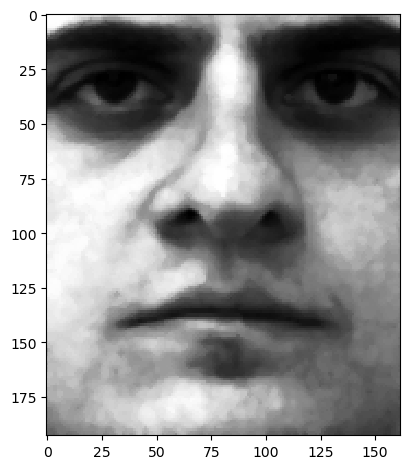

In [15]:
io.imshow(imgs[0])

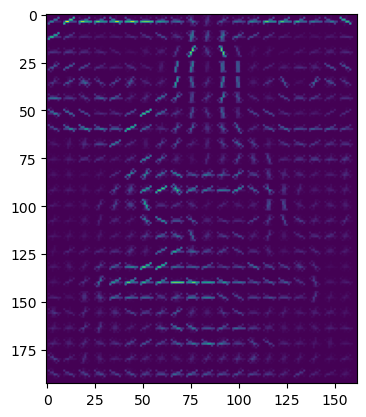

In [16]:
from matplotlib import pyplot as plt

plt.imshow(hog_images[0])

# 3. Modeling

### 3.1 Set random state

In [17]:
# Set random state so that results are reproducible
RANDOM_STATE = 27

### 3.2 Create grids for grid search

In [18]:
# Define grids

DecisionTreeClassifier_grid = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__min_samples_split': [2, 3, 4],
    'model__max_features': ['log2', 'sqrt', None],
    'model__class_weight': ['balanced', None]
}

RandomForestClassifier_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_features': ['log2', 'sqrt', None],
    'model__class_weight': ['balanced', None]
}

LogisticRegression_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.5, 1.0, 1.5],
    'model__solver': ['liblinear']
}

SVM_grid = {
    'model__C': [0.5, 1.0, 1.5],
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__gamma': ['scale', 'auto'],
    'model__class_weight': ['balanced', None]
}

# MultinomialNB_grid = {
#     'model__alpha': [1.0, 1.5, 2.0],
#     'model__fit_prior': [True, False]
# }

SGDClassifier_grid = {
    'model__loss': ['hinge'],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate': ['constant', 'optimal'],
    'model__eta0' : [0.001, 0.1]
}

LinearSVC_grid = {
    'model__C': [0.5, 1.0, 1.5, 2.0],
    'model__loss': ['squared_hinge', 'hinge'], 
    'model__class_weight': ['balanced', None]  
}

grids = {
    'dtc': DecisionTreeClassifier_grid,
    'rfc': RandomForestClassifier_grid,
    'lr': LogisticRegression_grid,
    'svm': SVM_grid,
    # 'mnb': MultinomialNB_grid,
    'lsvc': LinearSVC_grid,
    'sgdc': SGDClassifier_grid
}

In [19]:
grids

{'dtc': {'model__criterion': ['gini', 'entropy', 'log_loss'],
  'model__min_samples_split': [2, 3, 4],
  'model__max_features': ['log2', 'sqrt', None],
  'model__class_weight': ['balanced', None]},
 'rfc': {'model__n_estimators': [50, 100, 200, 300],
  'model__criterion': ['gini', 'entropy', 'log_loss'],
  'model__max_features': ['log2', 'sqrt', None],
  'model__class_weight': ['balanced', None]},
 'lr': {'model__penalty': ['l1', 'l2'],
  'model__C': [0.5, 1.0, 1.5],
  'model__solver': ['liblinear']},
 'svm': {'model__C': [0.5, 1.0, 1.5],
  'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
  'model__gamma': ['scale', 'auto'],
  'model__class_weight': ['balanced', None]},
 'lsvc': {'model__C': [0.5, 1.0, 1.5, 2.0],
  'model__loss': ['squared_hinge', 'hinge'],
  'model__class_weight': ['balanced', None]},
 'sgdc': {'model__loss': ['hinge'],
  'model__alpha': [0.0001, 0.001, 0.01],
  'model__learning_rate': ['constant', 'optimal'],
  'model__eta0': [0.001, 0.1]}}

### 3.3 Create models

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

# Create models

DecisionTreeClassifier_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
RandomForestClassifier_model = RandomForestClassifier(random_state=RANDOM_STATE)
LogisticRegression_model = LogisticRegression(random_state=RANDOM_STATE)
SVM_model = SVC(random_state=RANDOM_STATE)
# MultinomialNB_model = MultinomialNB()
SGDClassifier_model = SGDClassifier(random_state=RANDOM_STATE)
LinearSVC_model = LinearSVC(random_state=RANDOM_STATE) 

models = {
    'dtc': DecisionTreeClassifier_model,
    'rfc': RandomForestClassifier_model,
    'lr': LogisticRegression_model,
    'svm': SVM_model,
    # 'mnb': MultinomialNB_model,
    'sgdc': SGDClassifier_model,
    'lsvc': LinearSVC_model
}

In [21]:
models

{'dtc': DecisionTreeClassifier(random_state=27),
 'rfc': RandomForestClassifier(random_state=27),
 'lr': LogisticRegression(random_state=27),
 'svm': SVC(random_state=27),
 'sgdc': SGDClassifier(random_state=27),
 'lsvc': LinearSVC(random_state=27)}

### 3.4 Create pipelines (perform standard scaling and principal component analysis [PCA] using 95% variance)

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create pipelines for easy processing
# Perform standard scaling
# Perform principal component analysis (PCA) using 95% of variance

pipelines = {}

for name, model in models.items():
    pipelines[name] = Pipeline([('scaler', StandardScaler()), ('pca', PCA(0.95)), ('model', model)])

In [23]:
pipelines

{'dtc': Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                 ('model', DecisionTreeClassifier(random_state=27))]),
 'rfc': Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                 ('model', RandomForestClassifier(random_state=27))]),
 'lr': Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                 ('model', LogisticRegression(random_state=27))]),
 'svm': Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                 ('model', SVC(random_state=27))]),
 'sgdc': Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                 ('model', SGDClassifier(random_state=27))]),
 'lsvc': Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                 ('model', LinearSVC(random_state=27))])}

### 3.5 Create stratified 10-fold cross-validator

In [24]:
from sklearn.model_selection import StratifiedKFold

number_folds = 10
cv = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_STATE)

### 3.6 Perform grid search

In [25]:
from sklearn.model_selection import GridSearchCV

# Evaluate cross-validated model performance on F-score
scoring = 'f1'

# List of [best_score_, best_params_, best_estimator_]
best_score_params_estimators = []

# For each classifier
for name in pipelines.keys():
    gs = GridSearchCV(estimator=pipelines[name],
                      param_grid=grids[name],
                      scoring=scoring,
                      n_jobs=-1,
                      verbose=1,
                      cv=cv,
                      return_train_score=True)

    gs = gs.fit(X, y)

    best_score_params_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of rank_test_score and std_test_score
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get important columns in cv_results
    important_columns = [
        'rank_test_score',
        'mean_test_score', 
        'std_test_score', 
        'mean_train_score', 
        'std_train_score',
        'mean_fit_time', 
        'std_fit_time',                        
        'mean_score_time', 
        'std_score_time'
    ]
    
    # Move important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write to cv_results file
    cv_results.to_csv(path_or_buf=name + '_cv_results.csv', index=False)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "c:\ProgramData\Anaconda3\lib\site-pa

Fitting 10 folds for each of 72 candidates, totalling 720 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\ProgramData\Anaconda3\lib

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 16 candidates, totalling 160 fits


### 3.7 Sort models in descending order of best F-score and display best parameters

In [26]:
# Sort best_score_params_estimators in descending order of the best_score_
sorted_best_score_params_estimators = sorted(best_score_params_estimators, key=lambda x: x[0], reverse=True)

for rank in range(len(sorted_best_score_params_estimators)):
    best_score, best_params, best_estimator = sorted_best_score_params_estimators[rank]

    print('Top', str(rank + 1))    
    print('%-15s' % 'best_score:', best_score)
    print('%-15s' % 'best_estimator:'.format(20), type(best_estimator[2]))
    print('%-15s' % 'best_params:'.format(20), best_params, end='\n\n')

Top 1
best_score:     0.9689706863391073
best_estimator: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
best_params:    {'model__alpha': 0.01, 'model__eta0': 0.001, 'model__learning_rate': 'constant', 'model__loss': 'hinge'}

Top 2
best_score:     0.9589091721599463
best_estimator: <class 'sklearn.svm._classes.SVC'>
best_params:    {'model__C': 0.5, 'model__class_weight': 'balanced', 'model__gamma': 'scale', 'model__kernel': 'sigmoid'}

Top 3
best_score:     0.9580011453695663
best_estimator: <class 'sklearn.linear_model._logistic.LogisticRegression'>
best_params:    {'model__C': 1.0, 'model__penalty': 'l1', 'model__solver': 'liblinear'}

Top 4
best_score:     0.9534547655600287
best_estimator: <class 'sklearn.svm._classes.LinearSVC'>
best_params:    {'model__C': 0.5, 'model__class_weight': 'balanced', 'model__loss': 'squared_hinge'}

Top 5
best_score:     0.9453958860150811
best_estimator: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
best_params:    {'m

In [27]:
cv_results

,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,...,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score
0,1,0.953455,0.034376,1.0,0.0,4.264077,0.471418,0.104052,0.016874,0.5,...,0.971429,1.0,0.923077,1.0,1.0,1.0,0.972973,1.0,0.909091,1.0
1,1,0.953455,0.034376,1.0,0.0,4.346382,0.524277,0.131659,0.018616,0.5,...,0.971429,1.0,0.923077,1.0,1.0,1.0,0.972973,1.0,0.909091,1.0
2,1,0.953455,0.034376,1.0,0.0,4.087424,0.631079,0.114418,0.026768,0.5,...,0.971429,1.0,0.923077,1.0,1.0,1.0,0.972973,1.0,0.909091,1.0
3,1,0.953455,0.034376,1.0,0.0,4.119434,0.565252,0.117408,0.022410,0.5,...,0.971429,1.0,0.923077,1.0,1.0,1.0,0.972973,1.0,0.909091,1.0
4,1,0.953455,0.034376,1.0,0.0,4.062675,0.609911,0.123388,0.019927,1.0,...,0.971429,1.0,0.923077,1.0,1.0,1.0,0.972973,1.0,0.909091,1.0
5,1,0.953455,0.034376,1.0,0.0,4.005289,0.481545,0.114408,0.021666,1.0,...,0.971429,1.0,0.923077,1.0,1.0,1.0,0.972973,1.0,0.909091,1.0
6,1,0.953455,0.034376,1.0,0.0,4.005725,0.535490,0.118803,0.023677,1.0,...,0.971429,1.0,0.923077,1.0,1.0,1.0,0.972973,1.0,0.909091,1.0
7,1,0.953455,0.034376,1.0,0.0,4.007722,0.427996,0.116411,0.020483,1.0,...,0.971429,1.0,0.923077,1.0,1.0,1.0,0.972973,1.0,0.909091,1.0
8,1,0.953455,0.034376,1.0,0.0,3.979851,0.311282,0.115315,0.014360,1.5,...,0.971429,1.0,0.923077,1.0,1.0,1.0,0.972973,1.0,0.909091,1.0
9,1,0.953455,0.034376,1.0,0.0,4.087135,0.263101,0.102757,0.015177,1.5,...,0.971429,1.0,0.923077,1.0,1.0,1.0,0.972973,1.0,0.909091,1.0


In [28]:
first_rank_model = sorted_best_score_params_estimators[0][2]
first_rank_model

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('model',
                 SGDClassifier(alpha=0.01, eta0=0.001, learning_rate='constant',
                               random_state=27))])

In [29]:
from sklearn.model_selection import cross_val_score

first_rank_cross_val_scores = cross_val_score(first_rank_model, X, y, cv=10)
first_rank_cross_val_scores

array([0.94444444, 0.97222222, 0.97222222, 1.        , 1.        ,
       1.        , 0.94444444, 0.97222222, 0.91666667, 0.91666667])

### 3.8 Perform bagging with first ranked model

In [30]:
from sklearn.ensemble import BaggingClassifier

bag_model = BaggingClassifier(
    base_estimator=first_rank_model, 
    n_estimators=100, 
    max_samples=0.8, 
    oob_score=True,
    random_state=RANDOM_STATE
)

bag_model.fit(X, y)
bag_model_oob_score = bag_model.oob_score_

In [31]:
bag_model_oob_score

0.9527777777777777

In [32]:
bag_model = BaggingClassifier(
    base_estimator=first_rank_model, 
    n_estimators=100, 
    max_samples=0.8, 
    oob_score=True,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

bag_model_cross_val_scores = cross_val_score(bag_model, X, y, cv=cv)
bag_model_cross_val_scores

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   46.3s remaining:  2.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   50.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   48.3s remaining:  2.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   51.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.1s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Don

array([0.88888889, 0.94444444, 1.        , 0.97222222, 0.94444444,
       0.94444444, 0.91666667, 1.        , 0.97222222, 0.91666667])

In [33]:
bag_model_cross_val_scores.mean()

0.9499999999999998

In [34]:
bag_model_cross_val_scores.std()

0.03469443332443556

In [35]:
first_rank_cross_val_scores.mean()

0.9638888888888888

In [36]:
first_rank_cross_val_scores.std()

0.030555555555555572

In [37]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

# Calculate f1, precision, recall, and roc auc scores first
# Calculate confusion matrix scores thereafter (cross_validate() does not support confusion matrix scoring)

# Use cv created earlier
bag_model_f1_prec_re_roc_auc_scores = cross_validate(bag_model, X, y, cv=cv, scoring=('f1', 'precision', 'recall', 'roc_auc'))

# https://scikit-learn.org/stable/modules/model_evaluation.html#using-multiple-metric-evaluation
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}

bag_model_confusion_matrix_scores = cross_validate(bag_model, X, y, cv=cv, scoring=confusion_matrix_scorer)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   47.1s remaining:  2.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   50.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.6s remaining:    4.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   52.7s remaining:  2.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   57.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Don

In [38]:
print('f1: ' + str(bag_model_f1_prec_re_roc_auc_scores['test_f1'].mean()))
print('precision: ' + str(bag_model_f1_prec_re_roc_auc_scores['test_precision'].mean()))
print('recall: ' + str(bag_model_f1_prec_re_roc_auc_scores['test_recall'].mean()))
print('roc auc: ' + str(bag_model_f1_prec_re_roc_auc_scores['test_roc_auc'].mean()))

f1: 0.9504295554759951
precision: 0.9498955722639932
recall: 0.9555555555555555
roc auc: 0.9929012345679012


In [39]:
bag_model_confusion_matrix_scores['test_tn']

array([15, 17, 18, 18, 16, 18, 15, 18, 17, 18])

In [40]:
bag_model_confusion_matrix_scores['test_fp']

array([3, 1, 0, 0, 2, 0, 3, 0, 1, 0])

In [41]:
bag_model_confusion_matrix_scores['test_fn']

array([1, 1, 0, 1, 0, 2, 0, 0, 0, 3])

In [42]:
bag_model_confusion_matrix_scores['test_tp']

array([17, 17, 18, 17, 18, 16, 18, 18, 18, 15])

<AxesSubplot:>

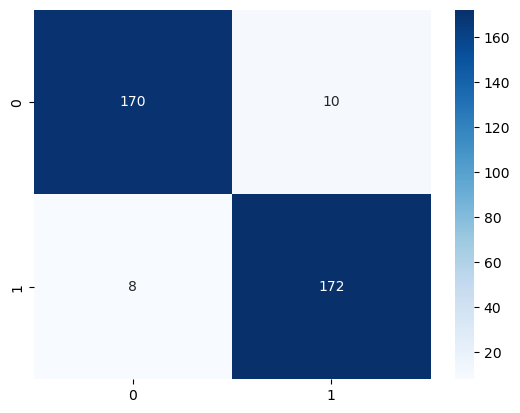

In [43]:
import seaborn as sns

# https://stackoverflow.com/questions/22404668/confusion-matrix-of-10-fold-cross-validation
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

total_tn = 0
total_fp = 0
total_fn = 0
total_tp = 0

for fold in range(0, number_folds):
    total_tn += bag_model_confusion_matrix_scores['test_tn'][fold]
    total_fp += bag_model_confusion_matrix_scores['test_fp'][fold]
    total_fn += bag_model_confusion_matrix_scores['test_fn'][fold]
    total_tp += bag_model_confusion_matrix_scores['test_tp'][fold]

cm_data = [[total_tn, total_fp], [total_fn, total_tp]]
sns.heatmap(cm_data, annot=True, cmap='Blues', fmt='d')

In [44]:
TP = total_tp
FN = total_fn
TN = total_tn
FP = total_fp

TPR = TP / (TP + FN) # Sensitivity, hit rate, recall, or true positive rate

TNR = TN / (TN + FP) # Specificity or true negative rate

PPV = TP / (TP + FP) # Precision or positive predictive value

NPV = TN / (TN + FN) # Negative predictive value

FPR = FP / (FP + TN) # Fall out or false positive rate

FNR = FN / (TP + FN) # False negative rate

FDR = FP / (TP + FP) # False discovery rate

# Overall accuracy
ACC = (TP + TN) / (TP + FP + FN + TN)

In [45]:
rates = {
    'rate': ['TPR', 'TNR', 'PPV', 'NPV', 'FPR', 'FNR', 'FDR'],
    'value': [TPR, TNR, PPV, NPV, FPR, FNR, FDR]
}

rates_df = pd.DataFrame(rates)

In [46]:
rates_df

,rate,value
0,TPR,0.955556
1,TNR,0.944444
2,PPV,0.945055
3,NPV,0.955056
4,FPR,0.055556
5,FNR,0.044444
6,FDR,0.054945


# 4. Champion Model Selection

### 4.1 Set bagging model as champion model

In [47]:
champion_model = bag_model

In [48]:
champion_model

BaggingClassifier(base_estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('pca',
                                                  PCA(n_components=0.95)),
                                                 ('model',
                                                  SGDClassifier(alpha=0.01,
                                                                eta0=0.001,
                                                                learning_rate='constant',
                                                                random_state=27))]),
                  max_samples=0.8, n_estimators=100, n_jobs=-1, oob_score=True,
                  random_state=27, verbose=1)

### 4.2 Save champion model using pickle and joblib for quick loading during testing by assessor

In [49]:
import pickle

pickled_champion_model_filename = 'pickled_champion_model.sav'
pickle.dump(champion_model, open(pickled_champion_model_filename, 'wb'))

In [50]:
loaded_pickled_champion_model = pickle.load(open(pickled_champion_model_filename, 'rb'))

In [51]:
loaded_pickled_champion_model

BaggingClassifier(base_estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('pca',
                                                  PCA(n_components=0.95)),
                                                 ('model',
                                                  SGDClassifier(alpha=0.01,
                                                                eta0=0.001,
                                                                learning_rate='constant',
                                                                random_state=27))]),
                  max_samples=0.8, n_estimators=100, n_jobs=-1, oob_score=True,
                  random_state=27, verbose=1)

In [52]:
import joblib

joblibed_champion_model_filename = 'joblibed_champion_model.sav'
joblib.dump(champion_model, joblibed_champion_model_filename)

['joblibed_champion_model.sav']

In [53]:
loaded_joblibed_champion_model = joblib.load(joblibed_champion_model_filename)

In [54]:
loaded_joblibed_champion_model

BaggingClassifier(base_estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('pca',
                                                  PCA(n_components=0.95)),
                                                 ('model',
                                                  SGDClassifier(alpha=0.01,
                                                                eta0=0.001,
                                                                learning_rate='constant',
                                                                random_state=27))]),
                  max_samples=0.8, n_estimators=100, n_jobs=-1, oob_score=True,
                  random_state=27, verbose=1)